In [1]:
from tqdm import tqdm
import numpy as np
from torchvision.datasets import CocoDetection
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import os
import gc
from multiprocessing import Pool
import shutil

In [5]:
SEED = 24
np.random.seed(SEED)
BASE_DIR = '/home/artem/data/COCO/CBIR_data'
tile_size = 256

In [3]:
coco_dataset = CocoDetection(root='/home/artem/data/COCO/train2017',
                             annFile='/home/artem/data/COCO/annotations/instances_train2017.json',
                             transform=np.array)

loading annotations into memory...
Done (t=6.87s)
creating index...
index created!


In [4]:
supercat_map = {0: 'background'}
cat_map = {0: 'background'}
for cat in coco_dataset.coco.getCatIds():
    supercat_map[cat] = coco_dataset.coco.loadCats([cat])[0]['supercategory']
    cat_map[cat] = coco_dataset.coco.loadCats([cat])[0]['name']

In [5]:
full_cat_file_idxs = defaultdict(int)
for image, target in tqdm(coco_dataset):
    mask = np.zeros(image.shape[:2])
    for elem in sorted(target, key=lambda x: -x['area']):
        mask[np.where(coco_dataset.coco.annToMask(elem) == 1)] = elem['category_id']
        
    h, w = image.shape[:2]
    results = []
    for x in range(0, w - tile_size, int(tile_size / 2)):
        for y in range(0, h - tile_size, int(tile_size / 2)):
            tile = mask[y:y + tile_size, x:x + tile_size]
            tile_class_idx = int(Counter(tile.ravel()).most_common(1)[0][0])
            tile_class = cat_map[tile_class_idx]
            tile_superclass = supercat_map[tile_class_idx]
            area = tile[tile == tile_class_idx].shape[0] / tile.ravel().shape[0] 
            
            full_cat_name = f'{tile_class}_{tile_superclass}'
            tile = image[y:y + tile_size, x:x + tile_size, :]
            file_idx = full_cat_file_idxs[full_cat_name]
            full_cat_file_idxs[full_cat_name] += 1
            file_name = f'{file_idx}_{full_cat_name}_{area:0.4f}.npy'
            dir_path = f'{BASE_DIR}/{full_cat_name}'
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            np.save(f'{dir_path}/{file_name}', tile)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118287/118287 [1:18:37<00:00, 25.07it/s]


In [6]:
class_to_files = defaultdict(list)
for class_name in os.listdir(f'{BASE_DIR}/raw_classes'):
    path = f'{BASE_DIR}/raw_classes/{class_name}'
    if os.path.isdir(path):
        n_files = len([name for name in os.listdir(path)])
        for name in os.listdir(path):
            class_to_files[class_name].append(f'{path}/{name}')

In [99]:
train = {}
val = {}
test = {}
N_TILES_PER_CLASS = 1000
# SPLIT WITH [70-15-15]%
for class_name, files in class_to_files.items():
    if len(files) >= N_TILES_PER_CLASS:
        sampled_files = np.array(files)[np.random.choice(len(files), size=N_TILES_PER_CLASS, replace=False)]
        train_thr = int(N_TILES_PER_CLASS * 0.7)
        val_thr = int(N_TILES_PER_CLASS * 0.85)
        train_files = sampled_files[:train_thr]
        val_files = sampled_files[train_thr:val_thr]
        test_files = sampled_files[val_thr:]

        train[class_name] = train_files
        val[class_name] = val_files
        test[class_name] = test_files

In [136]:
for name, data in zip(('train', 'val', 'test'),
                      (train,    val,   test)):
    dir_path = f'{BASE_DIR}/{name}'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    for class_name, files in data.items():
        for file in files:
            shutil.copy(file, f'{dir_path}/{file.split("/")[-1]}')

In [10]:
test_class_to_tiles = defaultdict(list)
for file in os.listdir(f'{BASE_DIR}/test'):
    split = file.split('_')
    class_name = split[1]
    test_class_to_tiles[class_name].append(f'{BASE_DIR}/test/{file}')

In [51]:
class_to_best_tile_idx = {
    'chair': 6,
    'tv': 13,
    'oven': 11,
    'cat': 2,
    'refrigerator': 13,
    'broccoli': 1,
    'bowl': 1,
    'pizza': 7,
    'cow': 0,
    'giraffe': 10,
    'boat': 2,
    'background': 3,
    'horse': 8,
    'bus': 13,
    'donut': 7,
    'teddy bear': 3,
    'sandwich': 7,
    'bed': 4,
    'bear': 12,
    'airplane': 13,
    'zebra': 6,
    'cake': 9,
    'car': 0,
    'elephant': 11,
    'suitcase': 12,
    'umbrella': 10,
    'hot dog': 14,
    'laptop': 10,
    'person': 6,
    'banana': 4,
    'truck': 8,
    'train': 7,
    'toilet': 6,
    'bench': 12,
    'couch': 3,
    'dog': 13,
    'dining table': 9,
    'motorcycle': 4,
    'potted plant': 4,
    'sheep': 9
}

superclass_to_best_tile_idx = {
    'furniture': [16, 20, 29],
    'electronic': [2, 12, 27],
    'appliance': [14, 19, 22],
    'animal': [1, 4, 6],
    'food': [3, 17, 28],
    'kitchen': [16, 20, 28],
    'vehicle': [6, 12, 23],
    'background': [3, 11, 18],
    'indoor': [4, 13, 26],
    'accessory': [0, 10, 28],
    'person': [6, 14, 22],
    'outdoor': [2, 15, 23]
}

In [43]:
for class_name, files in test_class_to_tiles.items():
    best_tile = sorted(files, key=lambda x: -float(x.split('_')[-1][:-4]))[class_to_best_tile_idx[class_name]]
    shutil.copy(best_tile, f'{BASE_DIR}/CBIR_test/class/query/{best_tile.split("/")[-1]}')
    for file in files:
        if file != best_tile:
            shutil.copy(file, f'{BASE_DIR}/CBIR_test/class/gallery/{file.split("/")[-1]}')

In [44]:
test_superclass_to_tiles = defaultdict(list)
for file in os.listdir(f'{BASE_DIR}/test'):
    split = file.split('_')
    superclass_name = split[2]
    test_superclass_to_tiles[superclass_name].append(f'{BASE_DIR}/test/{file}')

In [53]:
for superclass_name, files in test_superclass_to_tiles.items():
    best_tiles = sorted(files, key=lambda x: -float(x.split('_')[-1][:-4]))
    best_tile_names = set()
    for idx in superclass_to_best_tile_idx[superclass_name]:
        cur_best_tile = best_tiles[idx]
        best_tile_names.add(cur_best_tile)
        shutil.copy(cur_best_tile, f'{BASE_DIR}/CBIR_test/superclass/query/{cur_best_tile.split("/")[-1]}')
    for file in files:
        if file not in best_tile_names:
            shutil.copy(file, f'{BASE_DIR}/CBIR_test/superclass/gallery/{file.split("/")[-1]}')

In [ ]:
n = 30
for class_name, files in test_superclass_to_tiles.items():
    best_tiles = sorted(files, key=lambda x: -float(x.split('_')[-1][:-4]))[:n]
    print(class_name)
    f, axarr = plt.subplots(n // 5, 5)
    f.set_dpi(500)
    for i in range(n):
        axarr[i // 5, i % 5].imshow(np.load(best_tiles[i]))
        axarr[i // 5, i % 5].axis('off')
        axarr[i // 5, i % 5].set_title(i)
    plt.show()

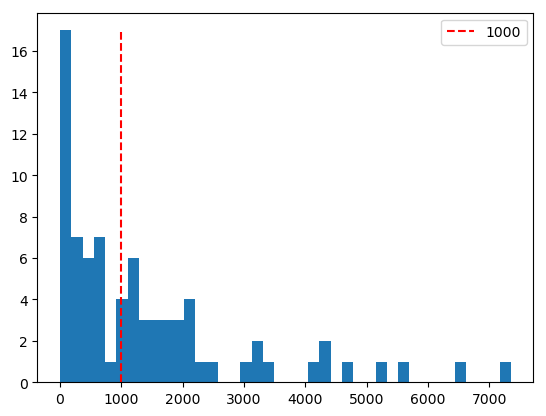

78


In [124]:
values = list(map(lambda x: len(x), class_to_files.values()))
values = np.array(values)
values = values[values < 1e4]
# values = values[values >= 1000]
plt.hist(values, bins=40)
plt.vlines(1000, 0, 17, label='1000', linestyles='--', colors='red')
plt.legend()
plt.show()
print(len(values))